Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
✅ XGBoost Test RMSE: 35.24
✅ XGBoost Test R²: 0.816


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


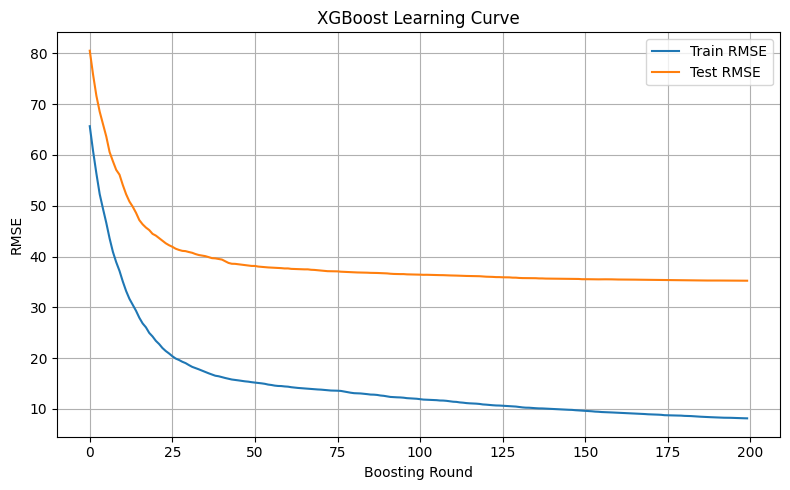

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import shap
import geopandas as gpd

df_model = pd.read_csv("london_model_with_poi.csv")

X = df_model.drop(columns=["Theft_Rate_per1k", "LSOA_Code"])
y = df_model["Theft_Rate_per1k"]
lsoa_code = df_model["LSOA_Code"].astype(str)

# -------------------------------
# 2. 划分训练集和测试集
# -------------------------------
X_train, X_test, y_train, y_test, lsoa_train, lsoa_test = train_test_split(
    X, y, lsoa_code, test_size=0.2, random_state=42
)

# -------------------------------
# 3. 构建 GridSearch + XGBoost 模型
# -------------------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ✅ 使用 kwargs 正确传递 eval_set 参数
grid_search.fit(
    X_train, y_train,
    **{
        "eval_set": [(X_train, y_train),(X_test, y_test)],
        "early_stopping_rounds": 10,
        "eval_metric": "rmse",
        "verbose": False
    }
)

# -------------------------------
# 4. 获取最佳模型并重新训练
# -------------------------------
best_model = grid_search.best_estimator_

# 获取训练过程记录
eval_result = best_model.evals_result()

# -------------------------------
# 5. 模型评估
# -------------------------------
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("✅ Best Parameters:", grid_search.best_params_)
print(f"✅ XGBoost Test RMSE: {rmse:.2f}")
print(f"✅ XGBoost Test R²: {r2:.3f}")

# -------------------------------
# 6. 绘制学习曲线
# -------------------------------
train_errors = eval_result['validation_0']['rmse']
test_errors = eval_result['validation_1']['rmse']

plt.figure(figsize=(8, 5))
plt.plot(train_errors, label="Train RMSE")
plt.plot(test_errors, label="Test RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")

Train RMSE: 8.17, R²: 0.99
Test RMSE: 35.24, R²: 0.82


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae_ols = 19.47107458813865
rmse_ols = 51.11156022088214
r2_ols = 0.474

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = rmse
r2_xgb = r2

print("📊 OLS:")
print(f"MAE:  {mae_ols:.2f}")
print(f"RMSE: {rmse_ols:.2f}")
print(f"R²:   {r2_ols:.3f}\n")

print("📊 XGBoost:")
print(f"MAE:  {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²:   {r2_xgb:.3f}")

📊 OLS:
MAE:  19.47
RMSE: 51.11
R²:   0.474

📊 XGBoost:
MAE:  8.13
RMSE: 35.24
R²:   0.816


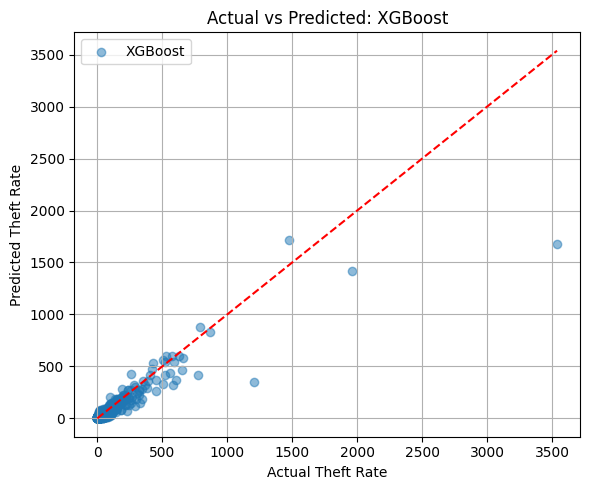

In [52]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5, label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Theft Rate")
plt.ylabel("Predicted Theft Rate")
plt.title("Actual vs Predicted: XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

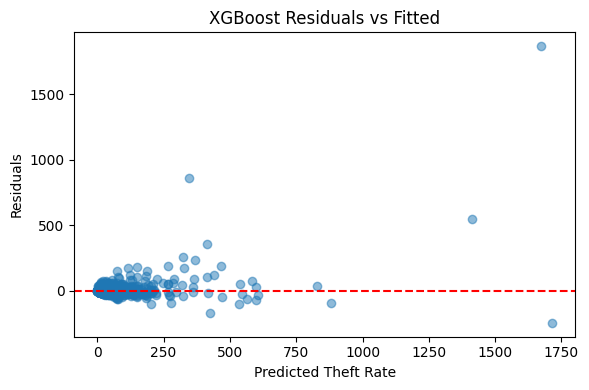

In [53]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Theft Rate")
plt.ylabel("Residuals")
plt.title("XGBoost Residuals vs Fitted")
plt.tight_layout()
plt.show()

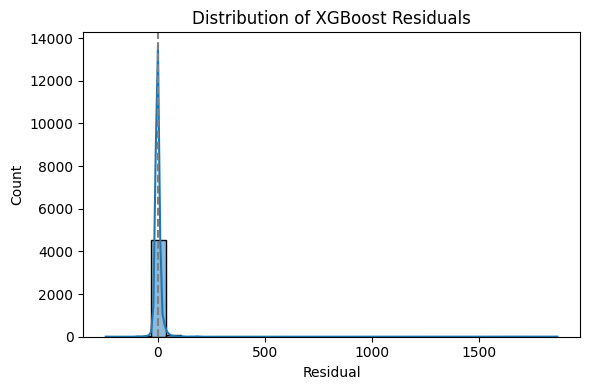

In [54]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Residual")
plt.title("Distribution of XGBoost Residuals")
plt.tight_layout()
plt.show()

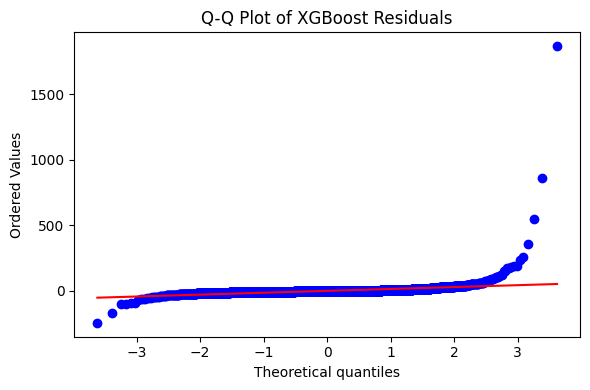

In [55]:
import scipy.stats as stats

plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of XGBoost Residuals")
plt.tight_layout()
plt.show()

In [19]:
# 如果你用了 XGBoost 的 scikit-learn API（XGBRegressor）：
explainer = shap.Explainer(best_model, X_train)

# 计算 SHAP 值
shap_values = explainer(X_train)


100%|===================| 18536/18612 [02:00<00:00]        

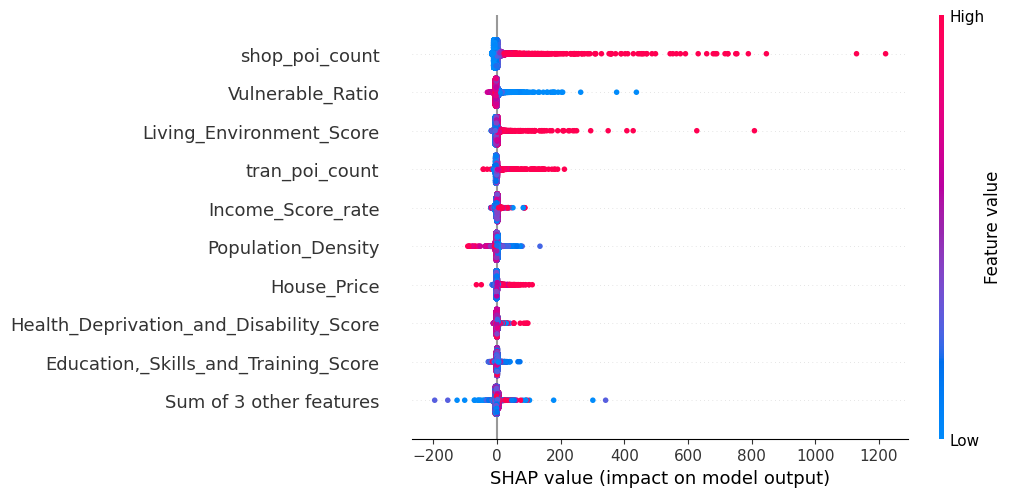

In [20]:
shap.plots.beeswarm(shap_values)

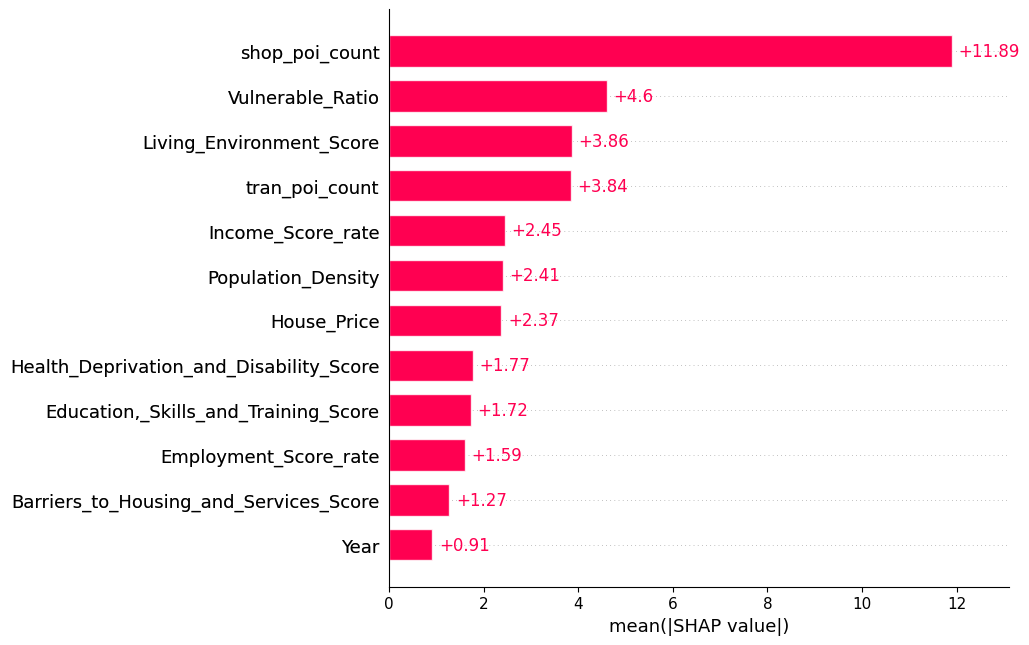

In [21]:
shap.plots.bar(shap_values, max_display=20)  # 显示前 20 个变量

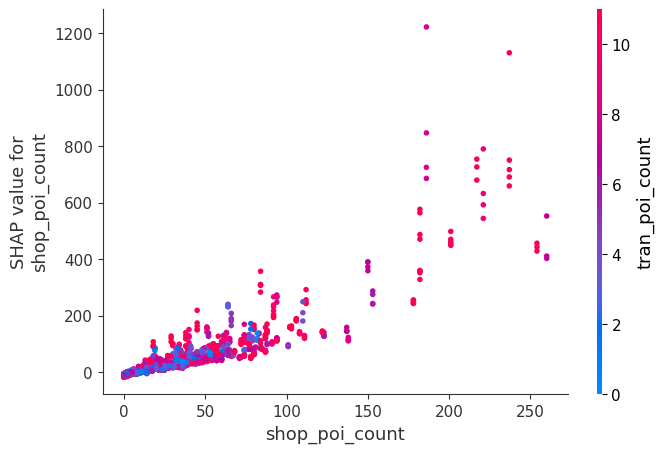

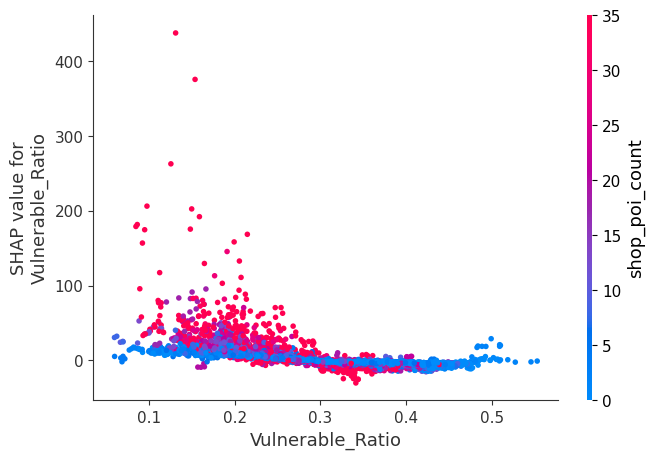

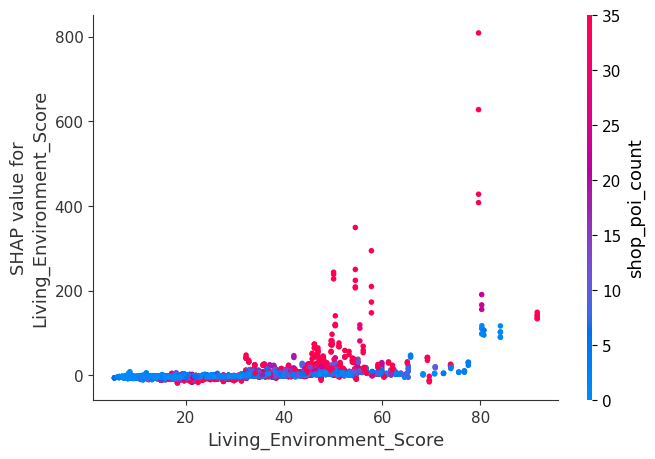

In [23]:
shap.dependence_plot("shop_poi_count", shap_values.values, X_train)
shap.dependence_plot("Vulnerable_Ratio", shap_values.values, X_train)
shap.dependence_plot("Living_Environment_Score", shap_values.values, X_train)

In [24]:
# 选择一个样本，比如第 10 个
shap.initjs()  # 启动 JS 显示（Jupyter环境需要）
shap.force_plot(
    base_value=shap_values.base_values[10],
    shap_values=shap_values.values[10],
    features=X_train.iloc[10],
    feature_names=X_train.columns
)


In [25]:
shap.initjs()
shap.force_plot(
    base_value=shap_values.base_values[20],
    shap_values=shap_values.values[20],
    features=X_train.iloc[20],
    feature_names=X_train.columns
)

In [26]:
lsoa_gdf = gpd.read_file("data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
lsoa_code = df_model.loc[X.index, "LSOA_Code"].astype(str)

lsoa_used = lsoa_code.unique()
lsoa_gdf = lsoa_gdf.rename(columns={"LSOA11CD": "LSOA_Code"})
lsoa_gdf = lsoa_gdf[lsoa_gdf["LSOA_Code"].isin(lsoa_used)].copy()

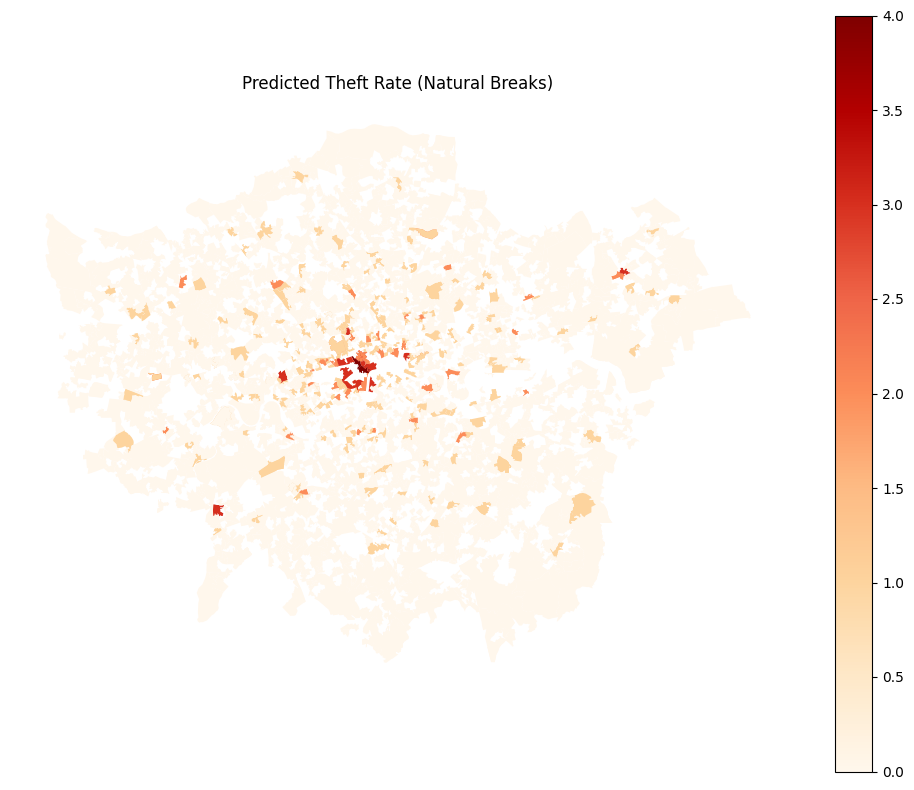

In [ ]:
df_pred = pd.DataFrame({
    "LSOA_Code": lsoa_test,
    "predicted_theft": y_pred
})

threshold = df_pred["predicted_theft"].quantile(0.90)
df_pred["hotspot"] = df_pred["predicted_theft"] >= threshold

pred_gdf = lsoa_gdf.merge(df_pred, on="LSOA_Code")

from mapclassify import NaturalBreaks  # 已内置于 geopandas 依赖里

# 你也可以在 GeoDataFrame 上直接用
classifier = NaturalBreaks(pred_gdf["predicted_theft"], k=5)  # k=层数

# 将分类结果加回 gdf
pred_gdf["theft_class"] = classifier.yb  # yb = 每个区域的类别编号

# 绘图
pred_gdf.plot(column="theft_class", cmap="OrRd", legend=True, figsize=(10, 8))
plt.title("Predicted Theft Rate (Natural Breaks)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [27]:
shap_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

shap_df["LSOA_Code"] = lsoa_train.reset_index(drop=True)
# 合并 SHAP 值进 lsoa_gdf
lsoa_gdf["LSOA_Code"] = lsoa_gdf["LSOA_Code"].astype(str)
gdf_with_shap = lsoa_gdf.merge(shap_df, on="LSOA_Code", how="left")

In [12]:
print(gdf_with_shap.head())


   LSOA_Code                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   
1  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   
2  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   
3  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   
4  E01000007  Barking and Dagenham 015A  E02000016  Barking and Dagenham 015   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000002  Barking and Dagenham  E12000007  London      1703      1699   
1  E09000002  Barking and Dagenham  E12000007  London      1703      1699   
2  E09000002  Barking and Dagenham  E12000007  London      1703      1699   
3  E09000002  Barking and Dagenham  E12000007  London      1703      1699   
4  E09000002  Barking and Dagenham  E12000007  London      1391      1391   

   ...  Vulnerable_Ratio  Population_Density  House_Pric

In [39]:
gdf_with_shap["centroid"] = gdf_with_shap.geometry.centroid
gdf_points = gdf_with_shap.set_geometry("centroid")

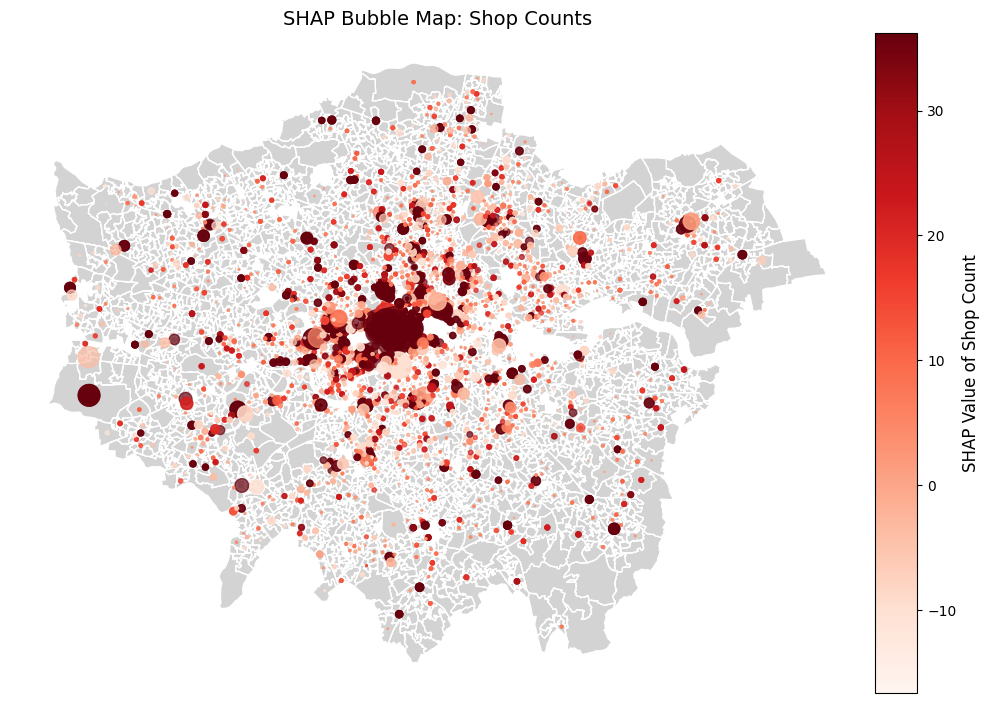

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

shop_shap = "shop_poi_count"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 背景图层
gdf_with_shap.plot(ax=ax, color="lightgrey", edgecolor="white")

# 气泡图（scatter 图层）
bubble = gdf_points.plot(
    ax=ax,
    column=shop_shap,
    cmap="Reds",
    markersize=gdf_points[shop_shap].clip(lower=0) * 0.5,  # 防止负值乘出负大小
    alpha=0.7,
    legend=False,  # 我们手动创建 colorbar
    vmax=gdf_with_shap[shop_shap].quantile(0.95)
)

# 创建 colorbar（颜色图例）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_points[shop_shap].min(),
        vmax=gdf_points[shop_shap].quantile(0.95)
    )
)
sm._A = []  # 这是 matplotlib 的黑魔法：为了让 colorbar 正常显示
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("SHAP Value of Shop Count", fontsize=12)

# 标题 + 美化
ax.set_title("SHAP Bubble Map: Shop Counts", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

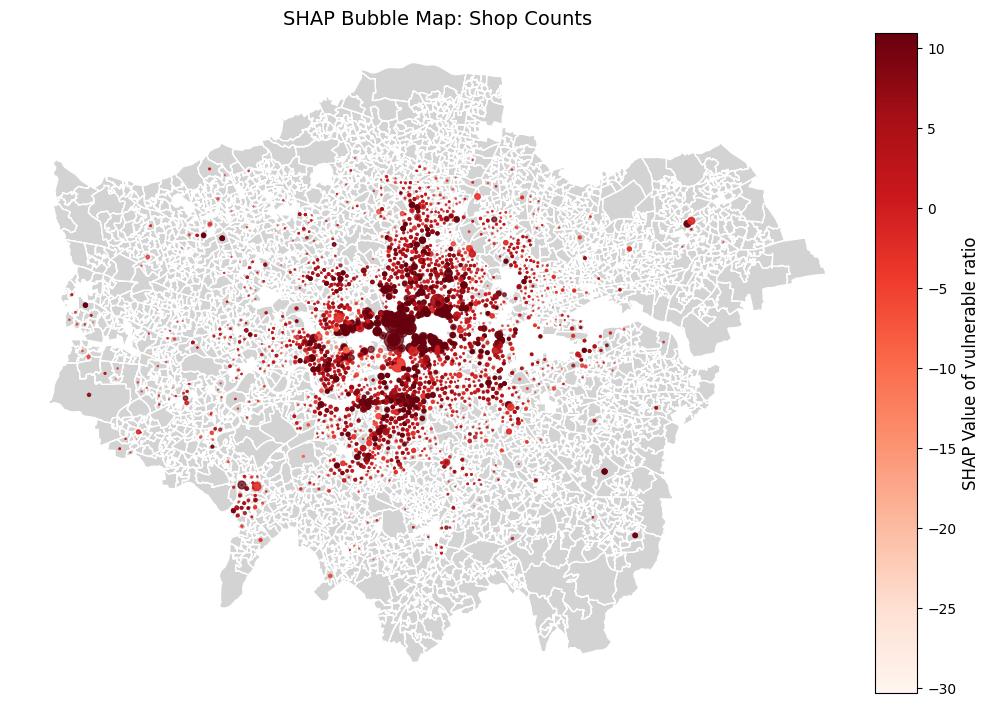

In [ ]:
vul_shap = "Vulnerable_Ratio"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 背景图层
gdf_with_shap.plot(ax=ax, color="lightgrey", edgecolor="white")

# 气泡图（scatter 图层）
bubble = gdf_points.plot(
    ax=ax,
    column=vul_shap,
    cmap="Reds",
    markersize=gdf_points[vul_shap].clip(lower=0) * 0.5,  # 防止负值乘出负大小
    alpha=0.7,
    legend=False,  # 我们手动创建 colorbar
    vmax=gdf_with_shap[vul_shap].quantile(0.95)
)

# 创建 colorbar（颜色图例）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_points[vul_shap].min(),
        vmax=gdf_points[vul_shap].quantile(0.95)
    )
)
sm._A = []  # 这是 matplotlib 的黑魔法：为了让 colorbar 正常显示
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("SHAP Value of vulnerable ratio", fontsize=12)

# 标题 + 美化
ax.set_title("SHAP Bubble Map: Shop Counts", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

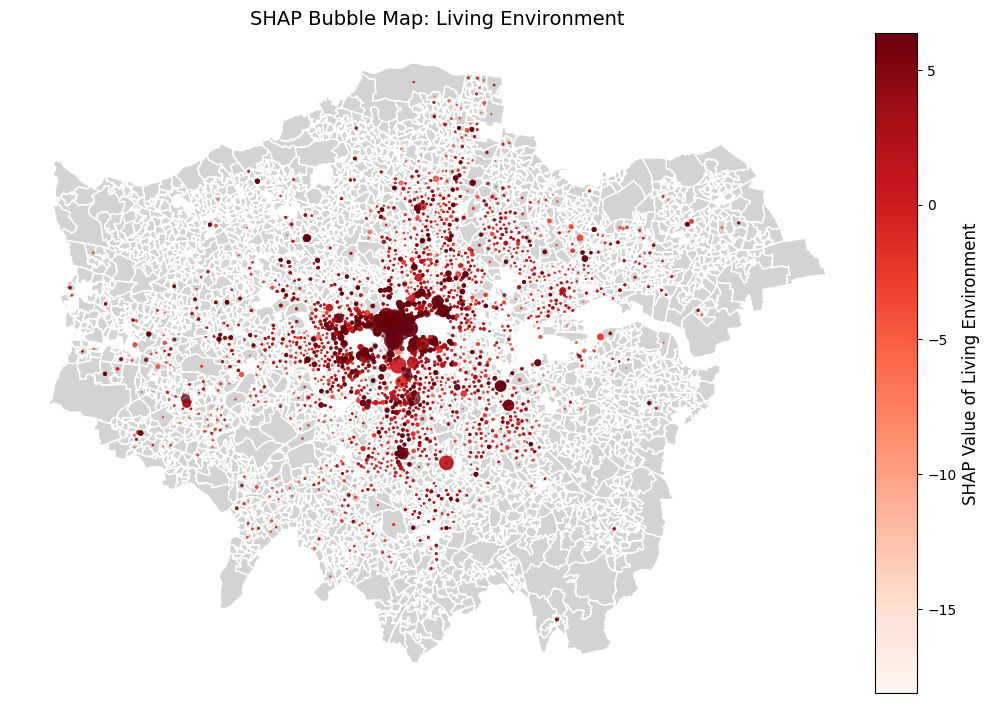

In [47]:
living_shap = "Living_Environment_Score"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 背景图层
gdf_with_shap.plot(ax=ax, color="lightgrey", edgecolor="white")

# 气泡图（scatter 图层）
bubble = gdf_points.plot(
    ax=ax,
    column=living_shap,
    cmap="Reds",
    markersize=gdf_points[living_shap].clip(lower=0) * 0.5,  # 防止负值乘出负大小
    alpha=0.7,
    legend=False,  # 我们手动创建 colorbar
    vmax=gdf_with_shap[living_shap].quantile(0.95)
)

# 创建 colorbar（颜色图例）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_points[living_shap].min(),
        vmax=gdf_points[living_shap].quantile(0.95)
    )
)
sm._A = []  # 这是 matplotlib 的黑魔法：为了让 colorbar 正常显示
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("SHAP Value of Living Environment", fontsize=12)

# 标题 + 美化
ax.set_title("SHAP Bubble Map: Living Environment", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

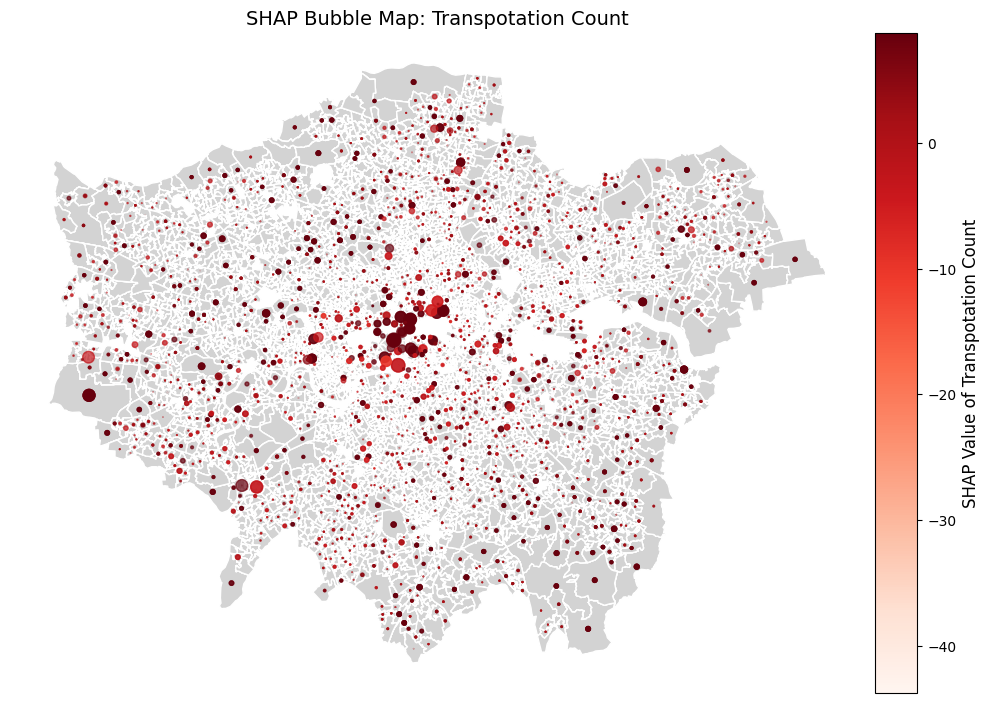

In [49]:
tran_shap = "tran_poi_count"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 背景图层
gdf_with_shap.plot(ax=ax, color="lightgrey", edgecolor="white")

# 气泡图（scatter 图层）
bubble = gdf_points.plot(
    ax=ax,
    column=tran_shap,
    cmap="Reds",
    markersize=gdf_points[tran_shap].clip(lower=0) * 0.5,  # 防止负值乘出负大小
    alpha=0.7,
    legend=False,  # 我们手动创建 colorbar
    vmax=gdf_with_shap[tran_shap].quantile(0.95)
)

# 创建 colorbar（颜色图例）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_points[tran_shap].min(),
        vmax=gdf_points[tran_shap].quantile(0.95)
    )
)
sm._A = []  # 这是 matplotlib 的黑魔法：为了让 colorbar 正常显示
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("SHAP Value of Transpotation Count", fontsize=12)

# 标题 + 美化
ax.set_title("SHAP Bubble Map: Transpotation Count", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# 获取残差最大的样本
top_error_idx = residuals.abs().sort_values(ascending=False).head(1).index[0]
top_row_number = X_test.index.get_loc(top_error_idx)
# 残差最小的
last_error_idx = residuals.abs().sort_values(ascending=True).head(1).index[0]
last_row_number = X_test.index.get_loc(last_error_idx)
# 预测值最大的
max_pred_idx = y_pred.argmax()
# 预测值最小的
min_pred_idx = y_pred.argmin()

In [ ]:
shap.initjs()  # 启动 JS 显示（Jupyter环境需要）
shap.force_plot(
    base_value=shap_values.base_values[max_pred_idx],
    shap_values=shap_values.values[max_pred_idx],
    features=X_train.iloc[max_pred_idx],
    feature_names=X_train.columns
)